In [ ]:
!pip install np_utils

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.callbacks import ReduceLROnPlateau

## Загрузите данные (MNIST.csv.zip)

Визуализируйте данные




In [ ]:
df = ...
print(df.shape)
df.head()

Выделите метки и признаки

In [ ]:
Y =
X =

Количество образцов для каждой цифры

In [ ]:
Y.value_counts()

In [ ]:
# plot some samples
img = X.iloc[10].to_numpy()
img = img.reshape((28,28))
plt.imshow(img,cmap='gray')
plt.title(df.iloc[10,0])
plt.axis("off")
plt.show()

## Нормализация, изменение формы и кодирование меток

**Нормализация**

Мы выполняем нормализацию в оттенках серого.

**Изменение формы**
Обучаем и тестируем изображения размером (28 x 28).
Преобразуем все данные в трехмерные матрицы 28x28x1.

**Кодирование меток**
Кодируем метки в "one hot vectors":

2 => [0,0,1,0,0,0,0,0,0,0]

4 => [0,0,0,0,1,0,0,0,0,0]

In [ ]:
# Normalize the data
X = X / 255.0
print("x_train shape: ",X.shape)

In [ ]:
# Reshape
X = X.values.reshape(-1,28,28,1)
print("x_train shape: ",X.shape)


In [ ]:
np.max(X), np.min(X)

In [ ]:
Y.shape

In [ ]:
# Label Encoding
Y = to_categorical(Y, num_classes = 10)

In [ ]:
Y

## Train/Test Split

Разделили данные на обучающий и тестовый наборы (90/10).

In [ ]:
X_train, X_val, Y_train, Y_val =

In [ ]:
Y_train.shape, Y_val.shape

In [ ]:
plt.imshow(X_train[2][:,:,0],cmap='gray')
plt.show()

## Модель сверточной нейронной сети

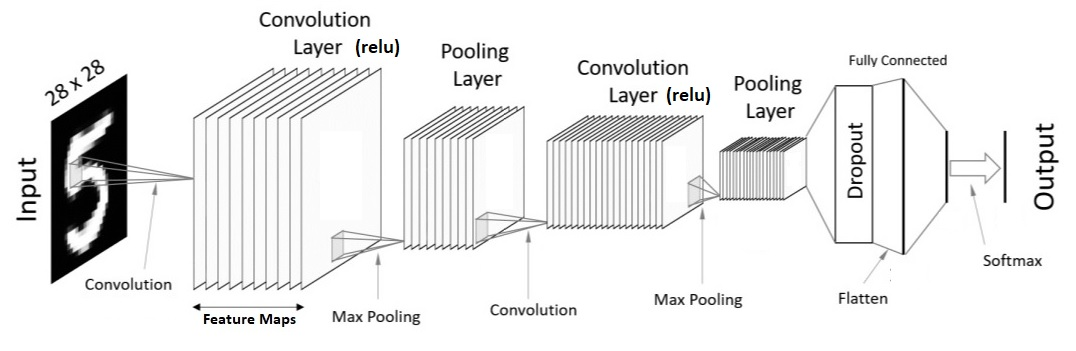

- У нас есть изображение и детектор признаков (3*3)
- Детектор признаков не обязательно должен быть матрицей 3 на 3. Он может быть 5 на 5 или 7 на 7.
- Детектор признаков = ядро ​​= фильтр
- Детектор признаков обнаруживает такие признаки, как края или выпуклые формы. Например, если на входе собака, детектор признаков может обнаружить такие признаки, как ухо или хвост собаки.
- Карта признаков = conv(входное изображение, детектор признаков). Поэлементное умножение матриц.
- Карта признаков = свернутый признак
- Шаг (Stride) = навигация по входному изображению.
- Мы уменьшаем размер изображения. Это важно, т. к. код работает быстрее. Однако мы теряем информацию.
- Мы создаем несколько карт признаков, т. к. используем несколько детекторов признаков (фильтров).

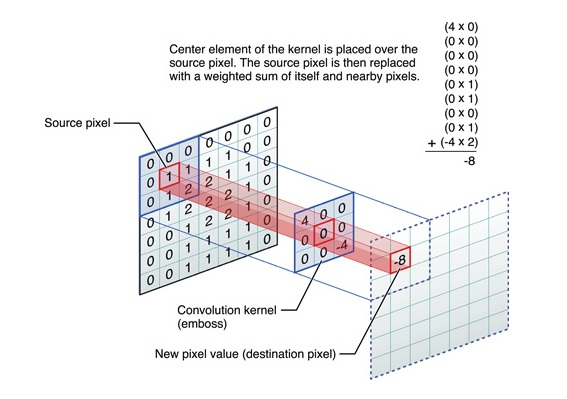

После того, как у нас есть сверточный слой, мы используем ReLU, чтобы внести нелинейность.

###Padding¶

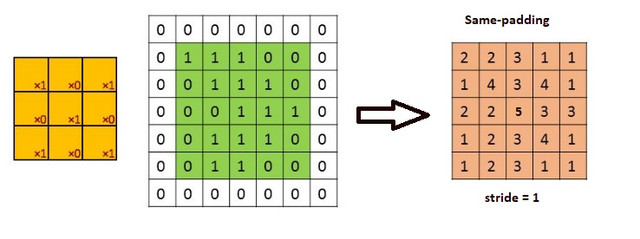

### Max Pooling¶

- уменьшает количество параметров
- обнаружение признаков становится инвариантным к изменениям масштаба или ориентации.
- уменьшает количество параметров и вычислений в сети, а следовательно, также контролирует переобучение.

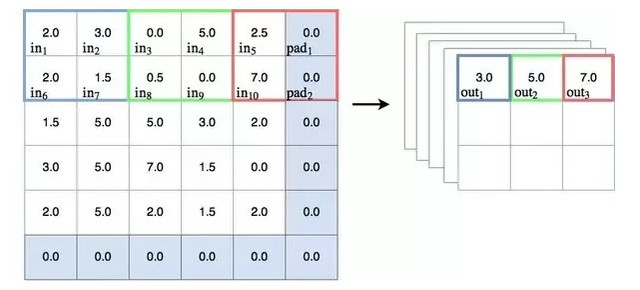

###Flattening (Сглаживание)
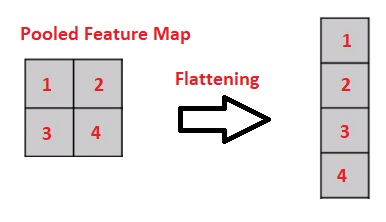

###Full connection (Полное соединение)

Нейроны в полностью связанном слое имеют соединения со всеми активациями в предыдущем слое.

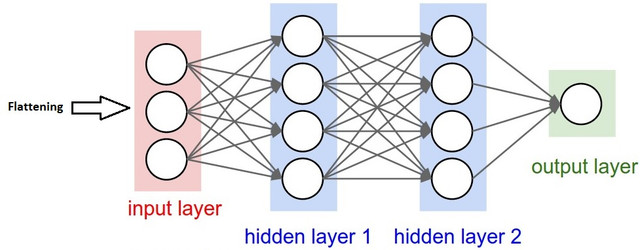

##Реализация с помощью Keras

conv => max pool => dropout => conv => max pool => dropout => fully connected (2 layer)

**Dropout** - это метод, при котором случайно выбранные нейроны игнорируются во время обучения

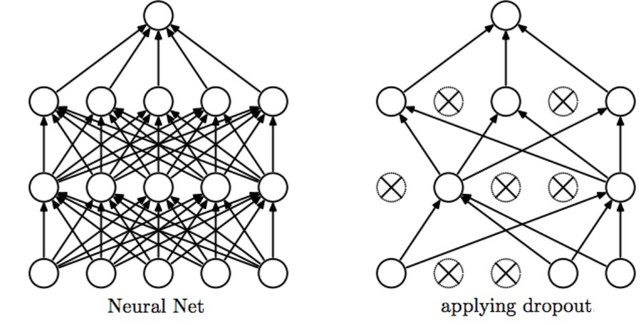

In [ ]:
model = Sequential()
#
model.add(Conv2D(filters = 8, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (28,28,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#Вставьте еще один слой
...

# fully connected
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

Используем категориальную кроссэнтропию

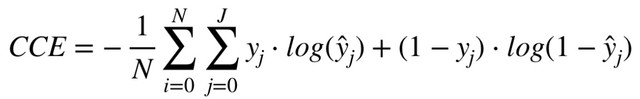

In [ ]:
model.compile(optimizer = Adam(), loss = "categorical_crossentropy", metrics=["accuracy"])

**Эпохи и размер пакета (batch_size)¶**

Допустим, у вас есть набор данных из 10 строк (или выборок). У вас есть размер пакета 2, и вы указали, что хотите, чтобы алгоритм работал в течение 3 эпох. Таким образом, в каждой эпохе у вас есть 5 пакетов (10/2 = 5). Каждый пакет проходит через алгоритм, поэтому у вас есть 5 итераций на эпоху.

In [ ]:
epochs = 4
batch_size = 250

##Расширение данных¶

Чтобы избежать проблемы переобучения, нам нужно искусственно расширить наш набор данных рукописных цифр.

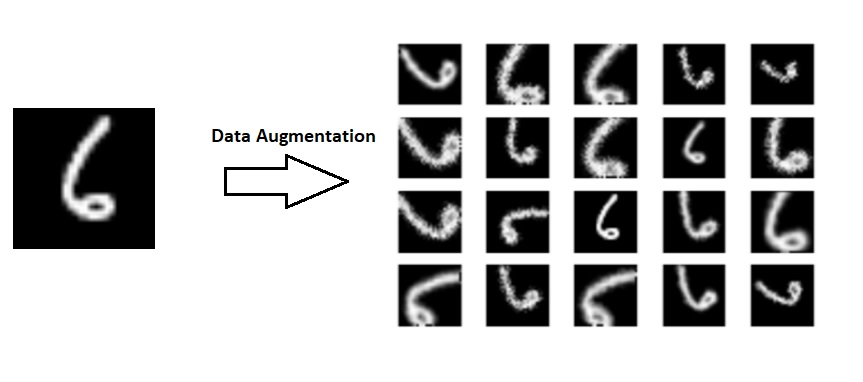

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # dimesion reduction
        rotation_range=5,  # randomly rotate images in the range 5 degrees
        zoom_range = 0.1, # Randomly zoom image 10%
        width_shift_range=0.1,  # randomly shift images horizontally 10%
        height_shift_range=0.1,  # randomly shift images vertically 10%
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

##Fit

In [ ]:
# Fit the model

history = model.fit(datagen.flow(X_train,Y_train, batch_size=batch_size),
                    epochs = epochs,
                    validation_data = (X_val,Y_val))

##Оценка модели¶

- Тестовая визуализация потерь и точности
- Матрица путаницы
- f1 score

In [ ]:
plt. ...

In [ ]:
import seaborn as sns

# Predict the values from the validation dataset
Y_pred =

# Convert predictions classes to one hot vectors
Y_pred_classes =

# Convert validation observations to one hot vectors
Y_true =

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Вычислите **f1_score**

In [3]:
...

Ellipsis

##Протестируйте модель на вашей картинке.

- Сделайте фото рукописной цифры.
- Сделайте необходимые преобразования картинки, чтобы ее можно было загрузить в нашу модель.